Loaded: (10000, 26)
After FE: (10000, 32)
X shape after dummies: (10000, 39)
Train dist: [6402 1598] Test dist: [1601  399]

=== EASY-ENSEMBLE baseline ===
Threshold=0.5000 -> Acc:0.4920 Prec:0.1967 Rec:0.5013 F1:0.2825 ROC-AUC:0.4913 PR-AUC:0.1968
Confusion matrix:
 [[784 817]
 [199 200]]


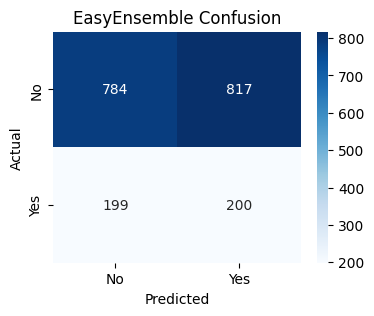


=== SMOTE resample + tuned models ===
Resampled: [6402 6402]
scale_pos_weight: 0.9999999999998437
RF best params: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 10}
XGB best params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1}

Training LogReg on SMOTE-resampled data...
Threshold=0.5000 -> Acc:0.5155 Prec:0.1981 Rec:0.4687 F1:0.2785 ROC-AUC:0.5006 PR-AUC:0.2047
Confusion matrix:
 [[844 757]
 [212 187]]


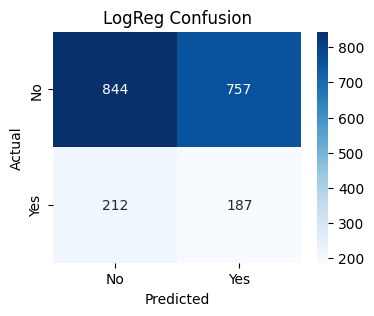


Training RandomForest on SMOTE-resampled data...
Threshold=0.5000 -> Acc:0.7695 Prec:0.2232 Rec:0.0627 F1:0.0978 ROC-AUC:0.5067 PR-AUC:0.2135
Confusion matrix:
 [[1514   87]
 [ 374   25]]


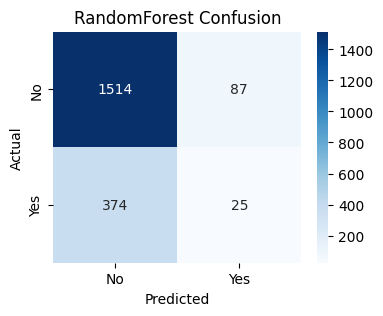


Training XGBoost on SMOTE-resampled data...
Threshold=0.5000 -> Acc:0.8005 Prec:0.5000 Rec:0.0025 F1:0.0050 ROC-AUC:0.4928 PR-AUC:0.2083
Confusion matrix:
 [[1600    1]
 [ 398    1]]


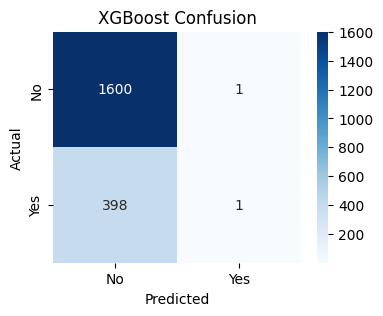


Training SVM on SMOTE-resampled data...
Threshold=0.5000 -> Acc:0.7025 Prec:0.2066 Rec:0.1729 F1:0.1883 ROC-AUC:0.5038 PR-AUC:0.2015
Confusion matrix:
 [[1336  265]
 [ 330   69]]


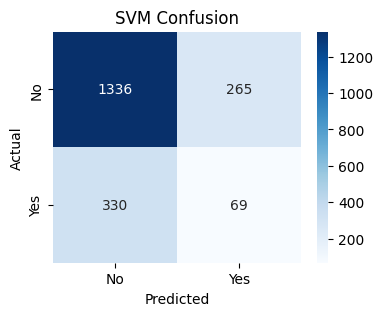


Base models summary (sorted by PR-AUC):
          Model   ROC-AUC    PR-AUC  Accuracy    Recall
1  RandomForest  0.506721  0.213466    0.7695  0.062657
2       XGBoost  0.492842  0.208251    0.8005  0.002506
0        LogReg  0.500622  0.204735    0.5155  0.468672
3           SVM  0.503819  0.201550    0.7025  0.172932

Top features from tree model:
Number_of_Companies_Worked       0.144489
Job_Involvement                  0.125905
Work_Environment_Satisfaction    0.097623
Performance_Rating               0.063460
Job_Satisfaction                 0.057516
Relationship_with_Manager        0.057514
Work_Life_Balance                0.044464
Job_Level                        0.041386
Marital_Status_Single            0.028288
Gender_Male                      0.027136
LowIncomeFlag                    0.023527
Marital_Status_Married           0.021611
Job_Role_Assistant               0.016203
Project_Count                    0.015143
Department_Marketing             0.014601
Job_Role_Manager  

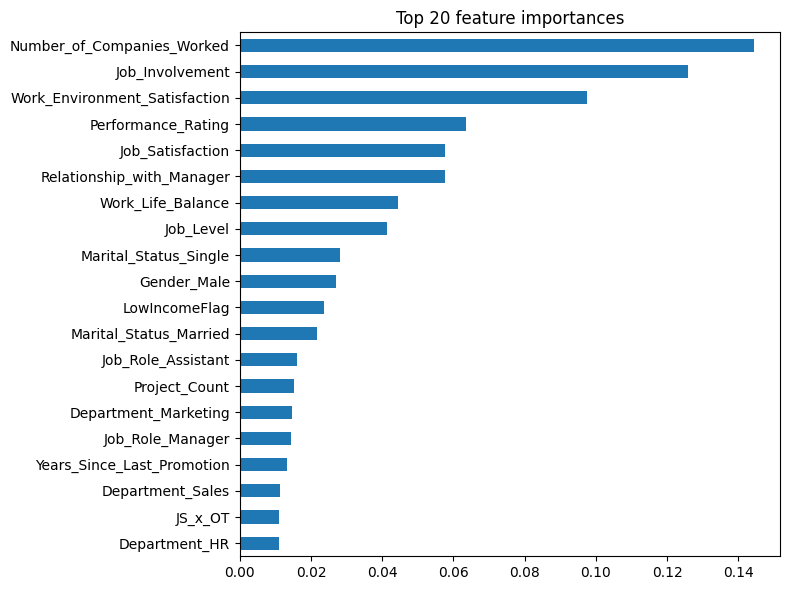


=== OOF stacking (no leakage) ===

Stacking base model: LogReg

Stacking base model: RandomForest

Stacking base model: XGBoost

Stacking base model: SVM


In [ ]:
# final_attrition_pipeline.py
"""
Final Attrition Pipeline
- Safe feature engineering
- EasyEnsemble baseline
- SMOTE resample + tuned base models
- OOF stacking (no leakage)
- Threshold tuning (PR-curve)
- Feature importances, diagnostics, and poster-ready charts
"""

import warnings
warnings.filterwarnings("ignore")

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix,
    brier_score_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
try:
    import lightgbm as lgb
    _lgb_available = True
except Exception:
    _lgb_available = False

try:
    from catboost import CatBoostClassifier
    _catboost_available = True
except Exception:
    _catboost_available = False

# -------------------------
# Utils
# -------------------------
def print_metrics(y_true, y_probs, threshold=0.5):
    y_pred = (y_probs > threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_probs) if len(np.unique(y_true))>1 else np.nan
    p, r, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(r, p)
    print(f"Threshold={threshold:.4f} -> Acc:{acc:.4f} Prec:{prec:.4f} Rec:{rec:.4f} F1:{f1:.4f} ROC-AUC:{roc:.4f} PR-AUC:{pr_auc:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    return {"acc":acc,"prec":prec,"rec":rec,"f1":f1,"roc":roc,"pr_auc":pr_auc, "cm":confusion_matrix(y_true, y_pred)}

def plot_confusion(cm, title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def safe_ratio(data, a,b,new):
    if a in data.columns and b in data.columns:
        data[new] = data[a] / (data[b] + 1e-9)
        return True
    return False

# -------------------------
# Main pipeline function
# -------------------------
def run_pipeline(DATA_PATH,
                 target_col="Attrition",
                 random_state=42,
                 test_size=0.2,
                 n_easy=10,
                 smote_random=42,
                 n_iter_search=6,
                 n_folds_stack=5,
                 save_dir="artifacts"):
    os.makedirs(save_dir, exist_ok=True)

    # Load
    df = pd.read_csv("/content/employee_attrition_dataset_10000.csv")
    print("Loaded:", df.shape)

    # Target encode
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found.")
    if df[target_col].dtype == object:
        df[target_col] = df[target_col].map({"Yes":1,"No":0}).fillna(df[target_col])
    if not np.issubdtype(df[target_col].dtype, np.number):
        df[target_col] = pd.factorize(df[target_col])[0]

    # Feature engineering (safe)
    data = df.copy()
    safe_ratio(data, "Monthly_Income", "Years_at_Company", "Income_per_YearAtCompany")
    safe_ratio(data, "Monthly_Income", "Age", "Income_per_Age")
    if "Years_at_Company" in data.columns and "TotalWorkingYears" in data.columns:
        data["YearsCompany_to_TotalYears"] = data["Years_at_Company"] / (data["TotalWorkingYears"] + 1e-9)
    if "Years_at_Company" in data.columns:
        data["TenureBucket"] = pd.cut(data["Years_at_Company"], bins=[-1,2,5,10,100], labels=["0-2","3-5","6-10","10+"])
    if "Overtime" in data.columns:
        data["OvertimeFlag"] = data["Overtime"].map({"Yes":1,"No":0})
        if data["OvertimeFlag"].isna().any():
            data["OvertimeFlag"] = pd.factorize(data["Overtime"].astype(str))[0]
    if "Monthly_Income" in data.columns:
        med_inc = data["Monthly_Income"].median()
        data["LowIncomeFlag"] = (data["Monthly_Income"] < med_inc).astype(int)
    for a,b,new in [("Job_Satisfaction","OvertimeFlag","JS_x_OT"),("Distance_From_Home","Years_at_Company","Dist_x_Tenure")]:
        if a in data.columns and b in data.columns:
            data[new] = data[a].astype(float) * data[b].astype(float)
    for col in ["Employee_ID","Employee_ID.1","EmployeeNumber","EmployeeCount","Over18","StandardHours"]:
        if col in data.columns:
            data.drop(columns=[col], inplace=True)
    print("After FE:", data.shape)

    # Prepare X,y and encode
    y = data[target_col].astype(int)
    X = data.drop(columns=[target_col])
    X = pd.get_dummies(X, drop_first=True)
    print("X shape after dummies:", X.shape)

    # Scale numeric
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state, stratify=y)
    print("Train dist:", np.bincount(y_train), "Test dist:", np.bincount(y_test))

    # ========== A: EasyEnsemble
    print("\n=== EASY-ENSEMBLE baseline ===")
    ee = EasyEnsembleClassifier(n_estimators=n_easy, random_state=random_state)
    ee.fit(X_train, y_train)
    try:
        ee_probs = ee.predict_proba(X_test)[:,1]
    except:
        ee_probs = ee.predict(X_test).astype(float)
    ee_metrics = print_metrics(y_test, ee_probs, threshold=0.5)
    plot_confusion(ee_metrics["cm"], "EasyEnsemble Confusion", save_path=os.path.join(save_dir,"easy_confusion.png"))

    # ========== B: SMOTE + tuned models
    print("\n=== SMOTE resample + tuned models ===")
    sm = SMOTE(random_state=smote_random)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    print("Resampled:", np.bincount(y_train_res))
    neg = np.sum(y_train_res==0); pos = np.sum(y_train_res==1)
    scale_pos_weight = neg/(pos+1e-9)
    print("scale_pos_weight:", scale_pos_weight)

    # RandomForest tuning
    rf = RandomForestClassifier(class_weight='balanced', random_state=random_state, n_jobs=-1)
    rf_param_dist = {'n_estimators':[100,200,300],'max_depth':[6,10,20,None],'min_samples_split':[2,5,10]}
    rf_search = RandomizedSearchCV(rf, rf_param_dist, n_iter=n_iter_search, scoring='recall', cv=3, random_state=random_state, n_jobs=-1)
    rf_search.fit(X_train_res, y_train_res)
    best_rf = rf_search.best_estimator_
    print("RF best params:", rf_search.best_params_)

    # XGBoost tuning
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state, n_jobs=-1)
    xgb_param_dist = {'n_estimators':[100,200],'max_depth':[3,4,6],'learning_rate':[0.01,0.05,0.1],'subsample':[0.6,0.8,1.0]}
    xgb_search = RandomizedSearchCV(xgb, xgb_param_dist, n_iter=n_iter_search, scoring='recall', cv=3, random_state=random_state, n_jobs=-1)
    xgb_search.fit(X_train_res, y_train_res)
    best_xgb = xgb_search.best_estimator_
    print("XGB best params:", xgb_search.best_params_)

    # SVM and Logistic
    svm = SVC(probability=True, class_weight='balanced', random_state=random_state)
    logreg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=random_state)

    models = {
        "LogReg": logreg,
        "RandomForest": best_rf,
        "XGBoost": best_xgb,
        "SVM": svm
    }
    if _catboost_available:
        models["CatBoost"] = CatBoostClassifier(verbose=0, random_state=random_state, auto_class_weights='Balanced')

    base_results = {}
    for name, m in models.items():
        print(f"\nTraining {name} on SMOTE-resampled data...")
        m.fit(X_train_res, y_train_res)
        if hasattr(m, "predict_proba"):
            probs = m.predict_proba(X_test)[:,1]
        else:
            try:
                scores = m.decision_function(X_test)
                probs = (scores - scores.min())/(scores.max()-scores.min()+1e-9)
            except:
                probs = m.predict(X_test).astype(float)
        base_results[name] = {"model": m, "probs": probs}
        _ = print_metrics(y_test, probs, threshold=0.5)
        plot_confusion(confusion_matrix(y_test, (probs>0.5).astype(int)), f"{name} Confusion", save_path=os.path.join(save_dir,f"{name}_confusion.png"))

    # Summary table
    summary = []
    for name, info in base_results.items():
        p, r, _ = precision_recall_curve(y_test, info["probs"])
        pr_auc = auc(r,p)
        roc = roc_auc_score(y_test, info["probs"])
        pred50 = (info["probs"]>0.5).astype(int)
        summary.append({"Model":name, "ROC-AUC":roc, "PR-AUC":pr_auc, "Accuracy":accuracy_score(y_test, pred50), "Recall":recall_score(y_test, pred50)})
    summary_df = pd.DataFrame(summary).sort_values(by="PR-AUC", ascending=False)
    print("\nBase models summary (sorted by PR-AUC):")
    print(summary_df)
    summary_df.to_csv(os.path.join(save_dir,"base_models_summary.csv"), index=False)

    # Feature importance (from XGBoost or RF)
    if "XGBoost" in base_results:
        imp_model = base_results["XGBoost"]["model"]
    elif "RandomForest" in base_results:
        imp_model = base_results["RandomForest"]["model"]
    else:
        imp_model = None

    if imp_model is not None and hasattr(imp_model, "feature_importances_"):
        importances = imp_model.feature_importances_
        feat_names = X.columns
        fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(30)
        print("\nTop features from tree model:")
        print(fi)
        plt.figure(figsize=(8,6))
        fi.head(20).plot(kind='barh')
        plt.gca().invert_yaxis()
        plt.title("Top 20 feature importances")
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir,"feature_importances.png"), dpi=300)
        plt.show()

    # -------------------------
    # OOF stacking (no leakage)
    # -------------------------
    print("\n=== OOF stacking (no leakage) ===")
    stack_models = [base_results[name]["model"] for name in base_results]
    stack_names = list(base_results.keys())

    NFOLDS = n_folds_stack
    skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=random_state)
    meta_train = np.zeros((X_train.shape[0], len(stack_models)))
    meta_test = np.zeros((X_test.shape[0], len(stack_models)))

    for idx, model in enumerate(stack_models):
        meta_test_fold_preds = np.zeros((X_test.shape[0], NFOLDS))
        oof_train = np.zeros(X_train.shape[0])
        print(f"\nStacking base model: {stack_names[idx]}")
        for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            X_tr_f, X_val_f = X_train[tr_idx], X_train[val_idx]
            y_tr_f, y_val_f = y_train.iloc[tr_idx], y_train.iloc[val_idx]
            X_tr_res, y_tr_res = SMOTE(random_state=smote_random).fit_resample(X_tr_f, y_tr_f)
            # clone and fit fresh to avoid cross-fold contamination
            try:
                # sklearn estimators are refitted safely
                model.fit(X_tr_res, y_tr_res)
            except Exception:
                # In case model instance changed state, instantiate a new one of same class (best-effort)
                model = model.__class__(**{k: getattr(model,k) for k in getattr(model,'get_params', lambda: {})().keys()})
                model.fit(X_tr_res, y_tr_res)

            if hasattr(model, "predict_proba"):
                oof_train[val_idx] = model.predict_proba(X_val_f)[:,1]
                meta_test_fold_preds[:, fold] = model.predict_proba(X_test)[:,1]
            else:
                try:
                    sc_v = model.decision_function(X_val_f)
                    sc_t = model.decision_function(X_test)
                    oof_train[val_idx] = (sc_v - sc_v.min())/(sc_v.max()-sc_v.min()+1e-9)
                    meta_test_fold_preds[:, fold] = (sc_t - sc_t.min())/(sc_t.max()-sc_t.min()+1e-9)
                except:
                    oof_train[val_idx] = model.predict(X_val_f)
                    meta_test_fold_preds[:, fold] = model.predict(X_test)

        meta_train[:, idx] = oof_train
        meta_test[:, idx] = meta_test_fold_preds.mean(axis=1)

    print("Meta_train shape:", meta_train.shape, "Meta_test shape:", meta_test.shape)

    # Balance meta_train
    meta_sm = SMOTE(random_state=smote_random)
    meta_X_train_res, meta_y_train_res = meta_sm.fit_resample(meta_train, y_train)
    print("Meta-train after SMOTE:", np.bincount(meta_y_train_res))

    # Meta-classifier
    if _lgb_available:
        meta_clf = lgb.LGBMClassifier(**{'n_estimators':200, 'random_state':random_state, 'class_weight':'balanced'})
    else:
        meta_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state, n_jobs=-1,
                                 scale_pos_weight=scale_pos_weight)

    meta_clf.fit(meta_X_train_res, meta_y_train_res)
    if hasattr(meta_clf, "predict_proba"):
        meta_probs = meta_clf.predict_proba(meta_test)[:,1]
    else:
        try:
            sc = meta_clf.decision_function(meta_test)
            meta_probs = (sc - sc.min())/(sc.max()-sc.min()+1e-9)
        except:
            meta_probs = meta_clf.predict(meta_test).astype(float)

    print("\nStacked model default threshold (0.5) metrics:")
    print_metrics(y_test, meta_probs, threshold=0.5)
    plot_confusion(confusion_matrix(y_test, (meta_probs>0.5).astype(int)), "Stacked Default Confusion", save_path=os.path.join(save_dir,"stacked_default_confusion.png"))

    # -------------------------
    # Threshold tuning (PR-curve)
    # -------------------------
    precisions, recalls, thresholds = precision_recall_curve(y_test, meta_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    # drop last precision/recall element that has no threshold mapping
    if len(f1_scores) > 1:
        best_idx = np.nanargmax(f1_scores[:-1])
        best_threshold = thresholds[best_idx]
    else:
        best_threshold = 0.5
    print(f"Best F1 threshold: {best_threshold:.6f} --> F1: {f1_scores[best_idx]:.4f} (if computable)")

    recall_target = 0.6
    chosen_t = best_threshold
    for t,pv,rv in zip(thresholds, precisions[:-1], recalls[:-1]):
        if rv >= recall_target and pv >= 0.15:
            chosen_t = t
            break

    print("Chosen threshold:", chosen_t)
    meta_pred_tuned = (meta_probs > chosen_t).astype(int)
    print("\nStacked tuned metrics:")
    print_metrics(y_test, meta_probs, threshold=chosen_t)
    plot_confusion(confusion_matrix(y_test, meta_pred_tuned), "Stacked Tuned Confusion", save_path=os.path.join(save_dir,"stacked_tuned_confusion.png"))

    # -------------------------
    # Final comparison table
    # -------------------------
    final_rows = []
    for name, info in base_results.items():
        probs = info["probs"]
        p, r, _ = precision_recall_curve(y_test, probs)
        pr_auc = auc(r,p)
        final_rows.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, (probs>0.5).astype(int)),
            "Precision": precision_score(y_test, (probs>0.5).astype(int), zero_division=0),
            "Recall": recall_score(y_test, (probs>0.5).astype(int), zero_division=0),
            "F1": f1_score(y_test, (probs>0.5).astype(int), zero_division=0),
            "ROC-AUC": roc_auc_score(y_test, probs),
            "PR-AUC": pr_auc
        })
    # stacked rows
    final_rows.append({
        "Model": "Stacked_default",
        "Accuracy": accuracy_score(y_test, (meta_probs>0.5).astype(int)),
        "Precision": precision_score(y_test, (meta_probs>0.5).astype(int), zero_division=0),
        "Recall": recall_score(y_test, (meta_probs>0.5).astype(int), zero_division=0),
        "F1": f1_score(y_test, (meta_probs>0.5).astype(int), zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, meta_probs),
        "PR-AUC": auc(recalls, precisions)
    })
    final_rows.append({
        "Model": "Stacked_tuned",
        "Accuracy": accuracy_score(y_test, meta_pred_tuned),
        "Precision": precision_score(y_test, meta_pred_tuned, zero_division=0),
        "Recall": recall_score(y_test, meta_pred_tuned, zero_division=0),
        "F1": f1_score(y_test, meta_pred_tuned, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, meta_probs),
        "PR-AUC": auc(recalls, precisions)
    })

    final_df = pd.DataFrame(final_rows).sort_values(by="Recall", ascending=False)
    print("\nFinal comparison sorted by Recall:")
    print(final_df)
    final_df.to_csv(os.path.join(save_dir,"final_comparison.csv"), index=False)

    # -------------------------
    # Save artifacts
    # -------------------------
    joblib.dump(scaler, os.path.join(save_dir,"scaler.joblib"))
    # save best base model artifacts
    joblib.dump(best_xgb, os.path.join(save_dir,"xgb_base.joblib"))
    joblib.dump(best_rf, os.path.join(save_dir,"rf_base.joblib"))
    joblib.dump(meta_clf, os.path.join(save_dir,"stacked_meta.joblib"))
    with open(os.path.join(save_dir,"chosen_threshold.txt"), "w") as f:
        f.write(str(chosen_t))

    print("\nSaved artifacts to", save_dir)
    print("Pipeline complete. Recommendations:")
    print("- Inspect top features and iterate on FE (temporal features help most).")
    print("- If stacked ROC-AUC ~0.5, add richer signals or check label noise.")
    print("- Remove SVM if runtime heavy or replace with linear SVM.")

    # Return objects useful for downstream tasks
    return {
        "scaler": scaler,
        "base_results": base_results,
        "meta_clf": meta_clf,
        "meta_probs": meta_probs,
        "chosen_threshold": chosen_t,
        "final_df": final_df,
        "X_columns": X.columns
    }

# -------------------------
# If run as script, call with DATA_PATH
# -------------------------
if __name__ == "__main__":
    # Adapt path as needed
    DATA_PATH = "/content/employee_attrition_dataset_10000.csv"
    artifacts = run_pipeline(DATA_PATH)


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

# ===============================
# 1. Load Dataset
# ===============================
data = pd.read_csv("/content/employee_attrition_dataset_10000.csv")
# Make sure dataset contains a column "Attrition" (Yes/No)

# Label encode categorical columns
le = LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = le.fit_transform(data[col])

# Split into features and label
X = data.drop("Attrition", axis=1)
y = data["Attrition"]

# ===============================
# 2. Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===============================
# 3. Train Model
# ===============================
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

print("Model training completed.")

# ===============================
# 4. Take User Input for Prediction
# ===============================

# -------------------------
# Interactive prediction UI
# Paste this single cell at the end of the notebook
# It assumes the notebook already has: X (features DataFrame used for training) and model (fitted)
# Optional: if you have a preprocessor (e.g., ColumnTransformer) named `preprocessor`, it will be used.
# -------------------------
# -------------------------
# Interactive prediction (improved prompts & exact headings)
# Paste this single cell at the end of the notebook (after training)
# -------------------------
# -------------------------
# Final interactive prediction cell (paste at the end of notebook after training)
# - Asks exactly the fields you listed
# - Omits integer-spec text for obvious numeric fields
# - Provides clear examples and inferred meaning for categorical/rating fields when possible
# -------------------------
# ---------------------------
# Complete notebook code block
#  - Load, label-encode (per-column), train, and interactive predict
# Paste into a notebook cell and run
# ---------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# ---------------------------
# 1) Load dataset
# ---------------------------
DATA_PATH = "/content/employee_attrition_dataset_10000.csv"  # update if needed
data = pd.read_csv(DATA_PATH)

# Ensure Attrition column exists
if "Attrition" not in data.columns:
    raise RuntimeError("Dataset must contain an 'Attrition' column (e.g., 'Yes'/'No').")

# ---------------------------
# 2) Label-encode categorical columns AND save per-column encoders
# ---------------------------
label_encoders = {}
for col in data.columns:
    if data[col].dtype == 'object' or data[col].dtype.name == 'category':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le

# ---------------------------
# 3) Prepare X and y
# ---------------------------
X = data.drop("Attrition", axis=1)
y = data["Attrition"]

# ---------------------------
# 4) Train-test split & model training
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

print("Model training completed.\n")

# ---------------------------
# 5) Interactive prediction (user-friendly, uses label_encoders mappings)
# Paste/Run this after training
# ---------------------------
requested_fields = [
    "Employee_ID","Age","Gender","Marital_Status","Department","Job_Role",
    "Job_Level","Monthly_Income","Hourly_Rate","Years_in_Current_Role",
    "Years_Since_Last_Promotion","Work_Life_Balance","Job_Satisfaction",
    "Performance_Rating","Training_Hours_Last_Year","Overtime","Project_Count",
    "Average_Hours_Worked_Per_Week","Work_Environment_Satisfaction",
    "Relationship_with_Manager","Job_Involvement","Distance_From_Home",
    "Number_of_Companies_Worked"
]

# Numeric fields for which we won't show encoded mappings or weird hints
plain_numeric = {
    "Employee_ID","Age","Monthly_Income","Hourly_Rate","Years_in_Current_Role",
    "Years_Since_Last_Promotion","Training_Hours_Last_Year","Project_Count",
    "Average_Hours_Worked_Per_Week","Distance_From_Home","Number_of_Companies_Worked"
}

print("=== Interactive prediction — enter values for each requested field ===")
print("If you don't know a value, press Enter to use a sensible default (median for numeric, first observed example for categorical).")
print("For encoded categorical fields you will see exact mappings (e.g. 0 = Female, 1 = Male). You may type either the label or the number.\n")

# Build user input dictionary
user_inputs = {}

for col in requested_fields:
    if col not in X.columns:
        print(f"Skipping (not in training features): {col}")
        continue

    # If we saved an encoder for this column, show mapping and accept human labels
    if col in label_encoders:
        le = label_encoders[col]
        classes = list(le.classes_)  # human-readable labels used during fit (strings)
        mapping = {i: cls for i, cls in enumerate(classes)}
        # Display mapping
        print(f"\n{col}: choose one of the following (you may type the label or the number):")
        for i, cls in mapping.items():
            print(f"  {i} = {cls}")
        # prompt loop
        while True:
            raw = input(f"Enter {col}: ").strip()
            if raw == "":
                # default -> first class
                default_label = classes[0]
                encoded = le.transform([default_label])[0]
                print(f" → Using default: {default_label} (encoded {encoded})")
                user_inputs[col] = encoded
                break
            # If user typed exact class label
            if raw in classes:
                encoded = le.transform([raw])[0]
                user_inputs[col] = int(encoded)
                break
            # If user typed an integer index
            if raw.isdigit():
                idx = int(raw)
                if idx in mapping:
                    user_inputs[col] = idx
                    break
                else:
                    print("  ✖ Invalid index. Choose one of the shown integers.")
                    continue
            # Try case-insensitive match to classes
            lowered = raw.lower()
            matched = None
            for cls in classes:
                if isinstance(cls, str) and cls.lower() == lowered:
                    matched = cls
                    break
            if matched is not None:
                encoded = le.transform([matched])[0]
                user_inputs[col] = int(encoded)
                break
            print("  ✖ Input not recognized. Enter a shown label or its number.")
    else:
        # Plain numeric column
        while True:
            raw = input(f"{col} (numeric) : ").strip()
            if raw == "":
                # default to median
                med = X[col].median() if X[col].dropna().shape[0] > 0 else 0
                default_val = int(med) if pd.api.types.is_integer_dtype(X[col]) else float(med)
                print(f" → Using default: {default_val}")
                user_inputs[col] = default_val
                break
            try:
                if pd.api.types.is_integer_dtype(X[col]):
                    user_inputs[col] = int(float(raw))
                else:
                    user_inputs[col] = float(raw)
                break
            except:
                print("  ✖ Invalid numeric input. Try again or press Enter for default.")
                continue

# Build input DataFrame aligned with training X columns
input_row = {c: user_inputs.get(c, 0) for c in X.columns}
input_df = pd.DataFrame([input_row], columns=X.columns)

# Coerce numeric columns to training dtypes where possible
for c in X.columns:
    try:
        if pd.api.types.is_integer_dtype(X[c]):
            input_df[c] = pd.to_numeric(input_df[c], errors='coerce').fillna(int(X[c].median())).astype(int)
        elif pd.api.types.is_float_dtype(X[c]):
            input_df[c] = pd.to_numeric(input_df[c], errors='coerce').fillna(float(X[c].median())).astype(float)
    except Exception:
        pass

# Final prediction
try:
    pred = model.predict(input_df)
except Exception as e:
    # attempt numpy conversion fallback
    try:
        pred = model.predict(np.asarray(input_df))
    except Exception as e2:
        raise RuntimeError(f"Prediction failed: {e} | fallback failed: {e2}")

res = pred[0] if hasattr(pred, '__len__') else pred

print("\n" + "="*40)
print("PREDICTION RESULT")
print("="*40 + "\n")
if isinstance(res, (int, np.integer, float, np.floating)) and (res in (0,1) or float(res).is_integer()):
    if int(res) == 1:
        print("🔴 Employee is LIKELY to LEAVE the company.")
    else:
        print("🟢 Employee will NOT leave the company.")
else:
    print("Model returned:", res)

print("\n(You can re-run this cell to predict another instance.)")



Model training completed.
Model training completed.

=== Interactive prediction — enter values for each requested field ===
If you don't know a value, press Enter to use a sensible default (median for numeric, first observed example for categorical).
For encoded categorical fields you will see exact mappings (e.g. 0 = Female, 1 = Male). You may type either the label or the number.

Employee_ID (numeric) : 5
Age (numeric) : 40

Gender: choose one of the following (you may type the label or the number):
  0 = Female
  1 = Male
Enter Gender: 1

Marital_Status: choose one of the following (you may type the label or the number):
  0 = Divorced
  1 = Married
  2 = Single
Enter Marital_Status: 1

Department: choose one of the following (you may type the label or the number):
  0 = Finance
  1 = HR
  2 = IT
  3 = Marketing
  4 = Sales
Enter Department: 1

Job_Role: choose one of the following (you may type the label or the number):
  0 = Analyst
  1 = Assistant
  2 = Executive
  3 = Manager
En